# 初始化全局变量

In [1]:
import torch
import torchvision 
from tqdm import tqdm
import matplotlib


In [2]:
#如果网络能在GPU中训练，就使用GPU；否则使用CPU进行训练
device = "cuda:0" if torch.cuda.is_available() else "cpu"

#这个函数包括了两个操作：将图片转换为张量，以及将图片进行归一化处理
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean = [0.5],std = [0.5])])


# 构建数据集

In [3]:
path = './data/'  #数据集下载后保存的目录

#下载训练集和测试集
trainData = torchvision.datasets.MNIST(path,train = True,transform = transform,download = True)
testData = torchvision.datasets.MNIST(path,train = False,transform = transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Pytorch中提供了一种叫做DataLoader的方法来让我们进行训练，该方法自动将数据集打包成为迭代器，能够让我们很方便地进行后续的训练处理

In [4]:
#设定每一个Batch的大小
BATCH_SIZE = 256  

#构建数据集和测试集的DataLoader
trainDataLoader = torch.utils.data.DataLoader(dataset = trainData,batch_size = BATCH_SIZE,shuffle = True)
testDataLoader = torch.utils.data.DataLoader(dataset = testData,batch_size = BATCH_SIZE)


# 训练部分

In [6]:
# 构建模型
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.model = torch.nn.Sequential(
            #The size of the picture is 28x28
            torch.nn.Conv2d(in_channels = 1,out_channels = 16,kernel_size = 3,stride = 1,padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2,stride = 2),
            
            #The size of the picture is 14x14
            torch.nn.Conv2d(in_channels = 16,out_channels = 32,kernel_size = 3,stride = 1,padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2,stride = 2),
            
            #The size of the picture is 7x7
            torch.nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size = 3,stride = 1,padding = 1),
            torch.nn.ReLU(),
            
            torch.nn.Flatten(),
            torch.nn.Linear(in_features = 7 * 7 * 64,out_features = 128),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features = 128,out_features = 10),
            torch.nn.Softmax(dim=1)
        )
        
    def forward(self,input):
        output = self.model(input)
        return output


In [7]:
net = Net()
#将模型转换到device中，并将其结构显示出来
print(net.to(device))  

Net(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=3136, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=10, bias=True)
    (12): Softmax(dim=1)
  )
)


# 构建迭代器与损失函数

In [8]:
lossF = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

# 训练循环代码
将上述两个循环进行结合，就是最终的训练循环代码了

In [9]:
EPOCHS = 10
#存储训练过程
history = {'Test Loss':[],'Test Accuracy':[]}
for epoch in range(1,EPOCHS + 1):
    processBar = tqdm(trainDataLoader,unit = 'step')
    net.train(True)
    for step,(trainImgs,labels) in enumerate(processBar):
        trainImgs = trainImgs.to(device)
        labels = labels.to(device)

        net.zero_grad()
        outputs = net(trainImgs)
        loss = lossF(outputs,labels)
        predictions = torch.argmax(outputs, dim = 1)
        accuracy = torch.sum(predictions == labels)/labels.shape[0]
        loss.backward()

        optimizer.step()
        processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f" % 
                                   (epoch,EPOCHS,loss.item(),accuracy.item()))
        
        if step == len(processBar)-1:
            correct,totalLoss = 0,0
            net.train(False)
            for testImgs,labels in testDataLoader:
                testImgs = testImgs.to(device)
                labels = labels.to(device)
                outputs = net(testImgs)
                loss = lossF(outputs,labels)
                predictions = torch.argmax(outputs,dim = 1)
                
                totalLoss += loss
                correct += torch.sum(predictions == labels)
            testAccuracy = correct/(BATCH_SIZE * len(testDataLoader))
            testLoss = totalLoss/len(testDataLoader)
            history['Test Loss'].append(testLoss.item())
            history['Test Accuracy'].append(testAccuracy.item())
            processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" % 
                                   (epoch,EPOCHS,loss.item(),accuracy.item(),testLoss.item(),testAccuracy.item()))
    processBar.close()


[1/10] Loss: 1.5961, Acc: 0.8438, Test Loss: 1.5867, Test Acc: 0.8556: 100%|██████████| 235/235 [00:57<00:00,  4.10step/s]
[2/10] Loss: 1.5855, Acc: 0.8854, Test Loss: 1.5688, Test Acc: 0.8719: 100%|██████████| 235/235 [00:56<00:00,  4.16step/s]
[3/10] Loss: 1.5831, Acc: 0.8854, Test Loss: 1.5657, Test Acc: 0.8746: 100%|██████████| 235/235 [00:55<00:00,  4.26step/s]
[4/10] Loss: 1.5817, Acc: 0.8542, Test Loss: 1.5601, Test Acc: 0.8799: 100%|██████████| 235/235 [01:14<00:00,  3.17step/s]
[5/10] Loss: 1.4612, Acc: 0.9792, Test Loss: 1.4743, Test Acc: 0.9640: 100%|██████████| 235/235 [00:55<00:00,  4.25step/s]
[6/10] Loss: 1.4612, Acc: 0.9792, Test Loss: 1.4720, Test Acc: 0.9666: 100%|██████████| 235/235 [01:14<00:00,  3.16step/s]
[7/10] Loss: 1.4612, Acc: 1.0000, Test Loss: 1.4737, Test Acc: 0.9646: 100%|██████████| 235/235 [00:56<00:00,  4.15step/s]
[8/10] Loss: 1.4612, Acc: 0.9896, Test Loss: 1.4715, Test Acc: 0.9663: 100%|██████████| 235/235 [01:15<00:00,  3.09step/s]
[9/10] Loss: 1.4

# 数据预后处理部分

## 训练结果可视化

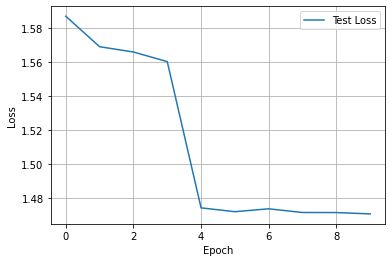

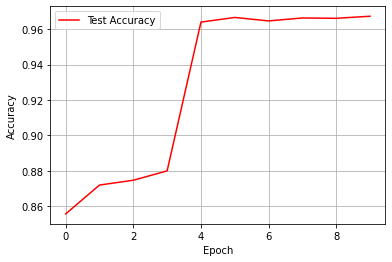

In [10]:
#对测试Loss进行可视化
matplotlib.pyplot.plot(history['Test Loss'],label = 'Test Loss')
matplotlib.pyplot.legend(loc='best')
matplotlib.pyplot.grid(True)
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Loss')
matplotlib.pyplot.show()

#对测试准确率进行可视化
matplotlib.pyplot.plot(history['Test Accuracy'],color = 'red',label = 'Test Accuracy')
matplotlib.pyplot.legend(loc='best')
matplotlib.pyplot.grid(True)
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Accuracy')
matplotlib.pyplot.show()


## 保存模型

In [11]:
torch.save(net,'./model.pth')

# 数据及的可视化

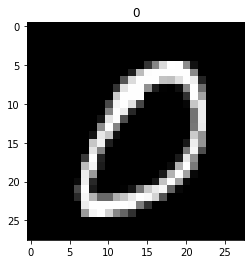

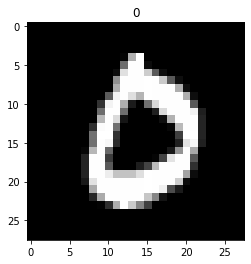

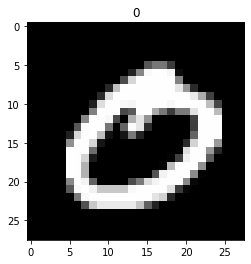

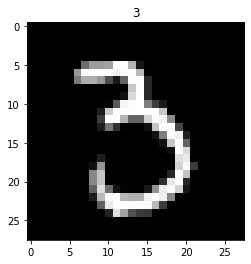

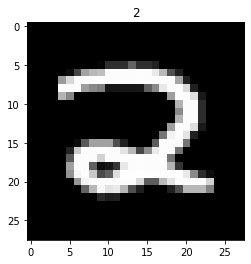

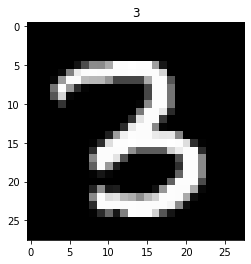

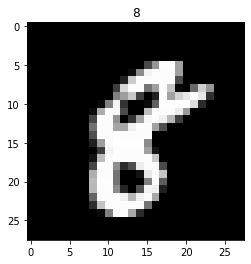

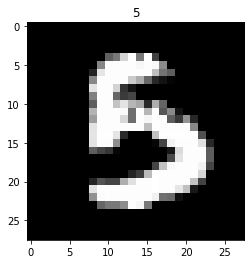

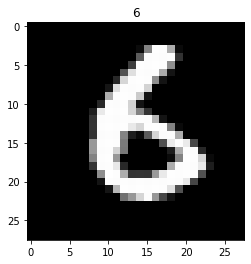

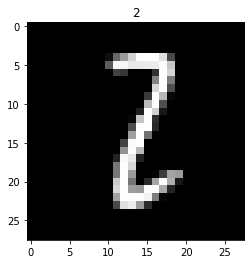

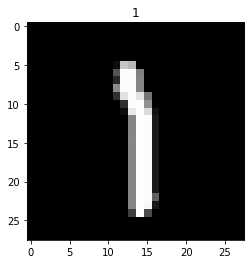

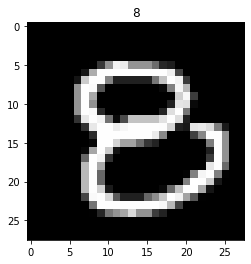

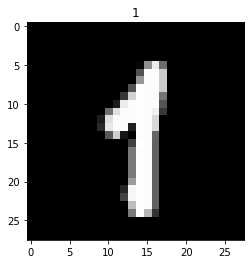

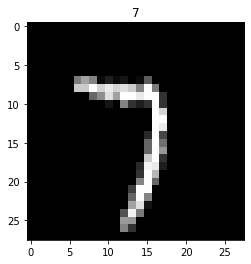

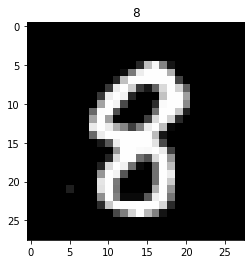

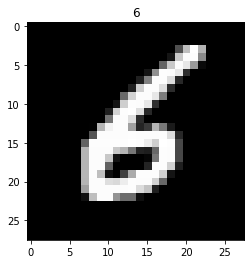

torch.Size([256])
torch.Size([256, 1, 28, 28])


In [26]:
# 对第一个batch的前16个输入和标签进行可视化
for step,(trainImgs,labels) in enumerate(trainDataLoader):
    trainImgs = trainImgs.to(device)
    labels = labels.to(device)

    for i in range(16):
      # ax1.imshow(x[i,0].numpy()*255, cmap=plt.cm.gray)
      matplotlib.pyplot.imshow(trainImgs[i,0].numpy()*255,cmap='gray')  #将像素转换为单通道照片，照片一般是3通道的rgb模式
      l = labels[i].item()
      matplotlib.pyplot.title(f"{l}")
      matplotlib.pyplot.show()

    print(labels.shape)
    print(trainImgs.shape)
    break